In [1]:
import os
from os.path import join
import re
import sys
import subprocess
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import sklearn
import random
import string 
import scipy
import seaborn as sns
from pickle import load, dump
from collections import Counter

import pprint

import gensim
from gensim.models import word2vec, Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models import KeyedVectors
from gensim.utils import tokenize
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud
from PIL import Image

import spacy

import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import unicodedata

import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install wordcloud
#!pip install pyLDAvis

In [3]:
%matplotlib inline

In [4]:
os.getcwd()

'C:\\Users\\vnarv\\PycharmProjects\\twitter_text_mining\\notebooks'

In [5]:
#path = "/home/onyxia/twitter_text_mining/"
path = "C:/Users/vnarv/PycharmProjects/twitter_text_mining/"
os.chdir(path)

In [6]:
from src.preprocessing.tools_preprocessing import *
from src.preprocessing.preprocessing_main import *

In [7]:
raw_data = read_files(os.path.join(path, "data/test/"))
print(raw_data.shape)
data = transform_dates(raw_data)
data = preprocessing(data)
data.to_csv(path + "/data/test/df_prepro.csv", sep=";", index=False)

C:\Users\vnarv\PycharmProjects\twitter_text_mining
Something went wrong
(19939, 8)
Nb of tweets detected in other language language
af     8
ca    10
cs     1
da     6
de    11
en    68
es     6
et     5
fi    18
hr     4
id     3
it    21
lt     5
lv     1
nl     5
no    20
pl     1
ro     3
sl     4
sv     2
Name: tweet_id, dtype: int64
                                             text_clean language
93          desescaladez vladimir par cocoboer ukraine        es
192   spanish minister of foreign affairs jose manue...       en
366    flash une invasion russe de l ukraine est pos...       en
386    g finance ministers statement on ukraine g g ger       en
430         convoidelaliberte ukraine atomium lesoirbe        it
677   soyons bref quoi que macron decide je m y oppo...       es
1148  ukraine foreign ministry recalls charge d affa...       en
1310  a la une de liberation ce mercredi ukraine fac...       it
1502          explosions in kyiv via neilphauer ukraine       fi
1540     

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vnarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data["text"].iloc[1]

'#ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv'

In [11]:
data["text_clean"].iloc[1]

'face poutine macron hausse'

In [17]:
data = pd.read_csv(path + "/data/test/df_prepro.csv", sep=";")

In [20]:
data.columns

Index(['datetime', 'tweet_id', 'text', 'username', 'like_count',
       'retweet_count', 'reply_count', 'quote_count', 'date', 'day', 'month',
       'time', 'hour', 'minute', 'hashtags', 'arrobas', 'text_clean',
       'language', 'text_stem', 'text_stem_bigrame', 'text_stem_trigrame',
       'text_lemma', 'text_lemma_bigrame', 'text_lemma_trigrame'],
      dtype='object')

In [12]:
data["text"].iloc[0]

"voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc"

In [13]:
data["text"].iloc[0]

"voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc"

In [14]:
data["text_clean"].iloc[0]

'info malheureusement tres peu reprise medias entretien telephonique jours entre emmanuelmacron vladimirpoutine'

In [24]:
data["text_clean"][1728]

'comme lors revolution maidan habitants kyiv ruent magasins alimentaires ukraine'

In [25]:
data["text_lemma_trigrame"][1728]

'comme_lors_revolution lors_revolution_maidan revolution_maidan_habitant maidan_habitant_kyiv habitant_kyiv_ruent kyiv_ruent_magasin ruent_magasin_alimentaires magasin_alimentaires_ukraine'

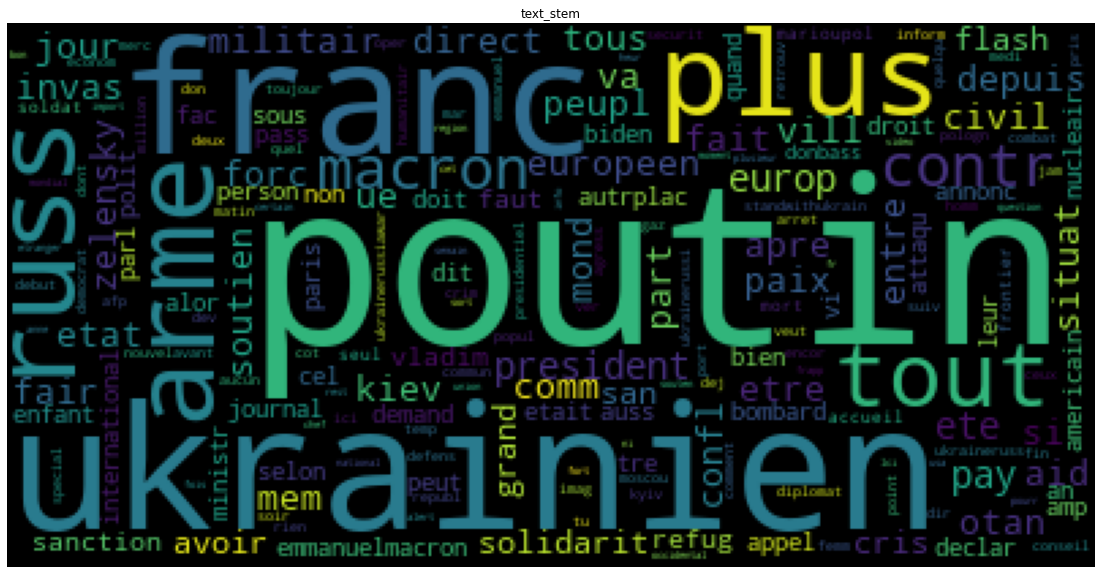

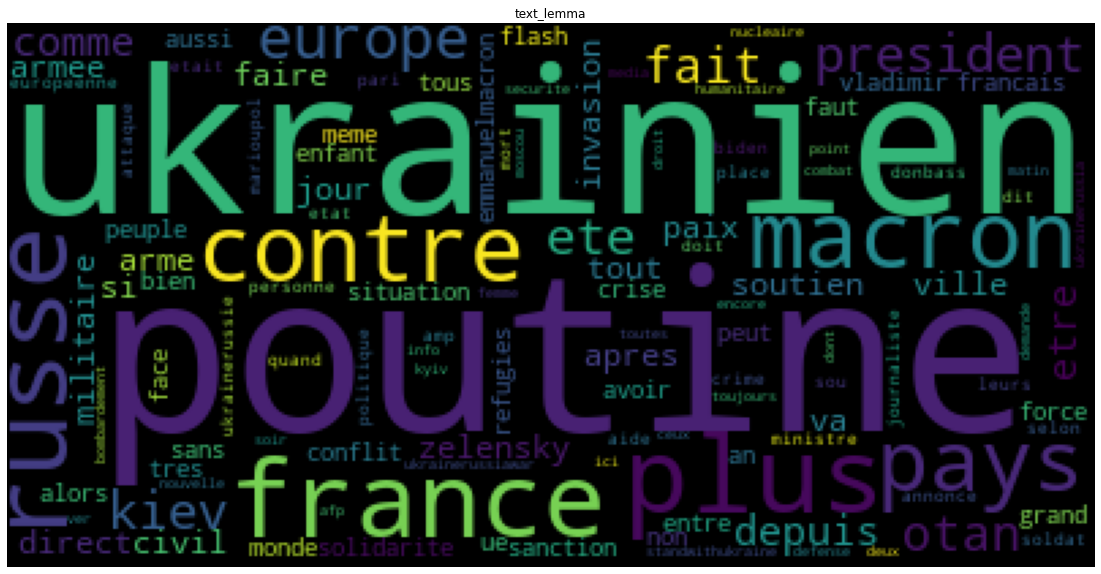

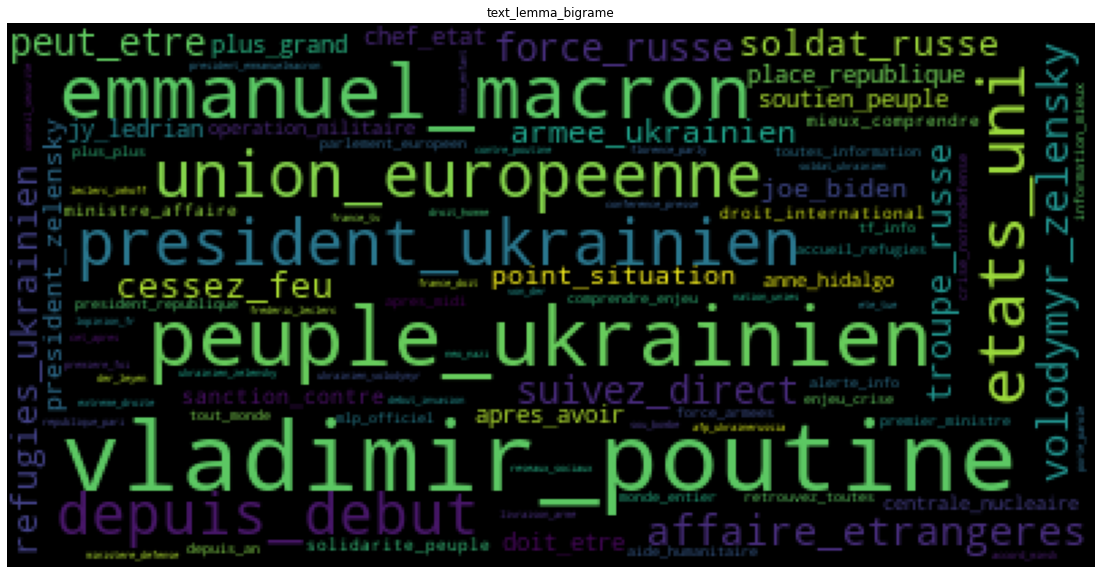

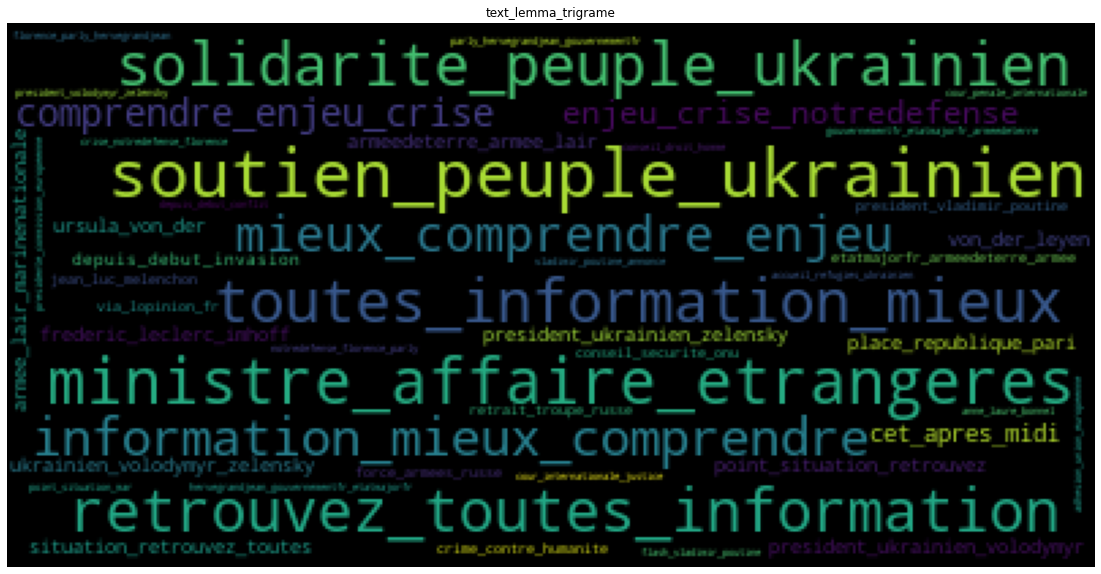

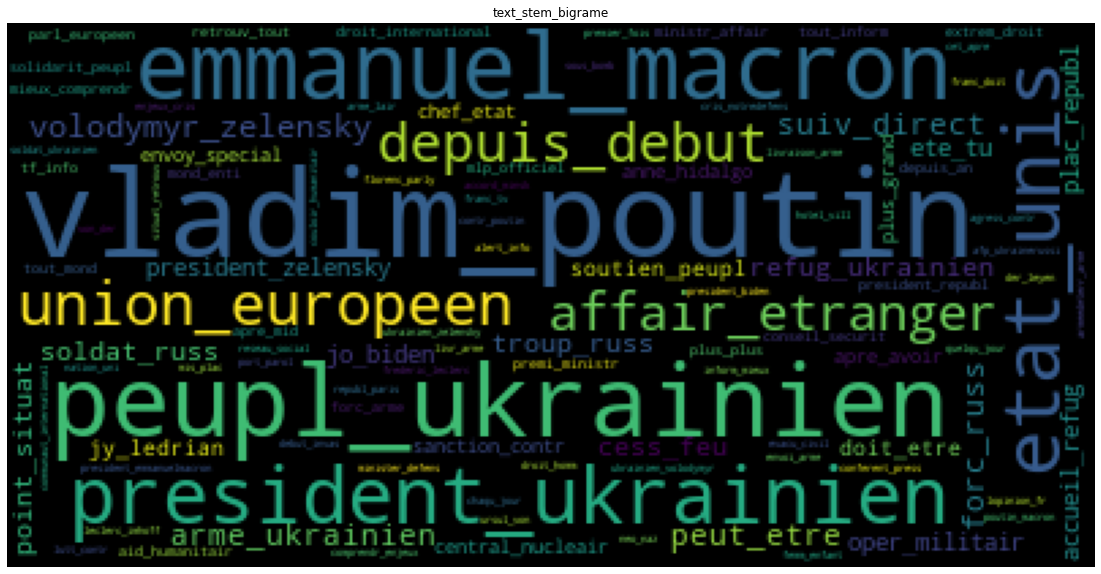

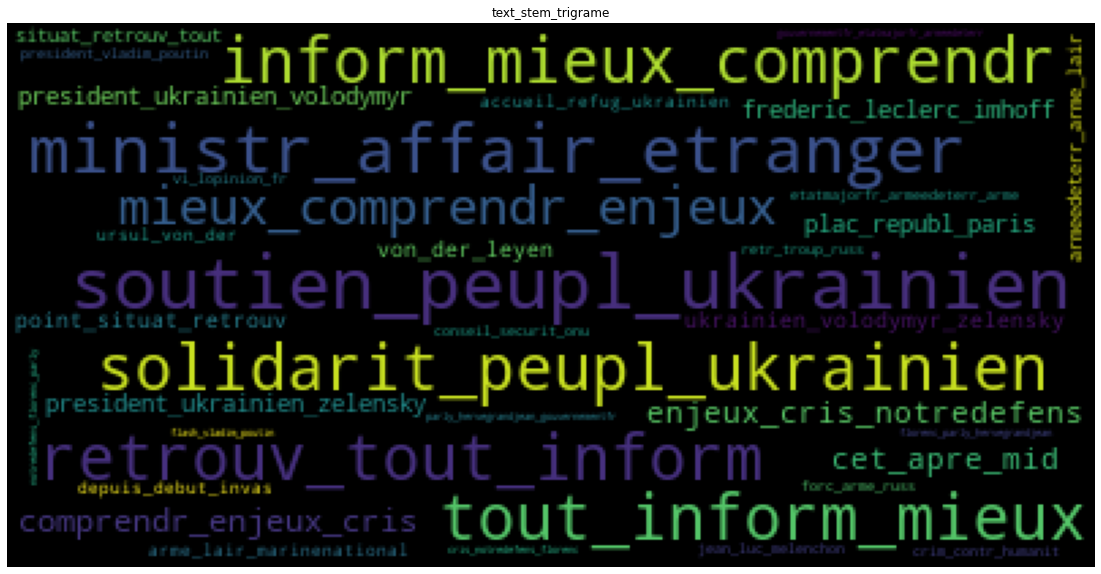

In [22]:
for method in ["text_stem", "text_lemma", "text_lemma_bigrame", "text_lemma_trigrame", "text_stem_bigrame", "text_stem_trigrame"]:
    words_t = ''
    for i in data[method]:
        try:
            words_t += '{} '.format(i.lower())
        except AttributeError:
            pass
    wd = pd.DataFrame(Counter(words_t.split()).most_common(), columns=['word', 'frequency_total'])
    tuples = [tuple(x) for x in wd.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.subplots(figsize=(20, 10)) 
    plt.imshow(wordcloud)
    plt.title(f"{method}") 
    plt.axis("off")
    plt.show()

# LDA

In [40]:
# vectorize
def compute_bag_of_words(df):
    df = df.dropna()
    # split each tweet sentence into words
    text_tokens = [[text for text in tweet.split()] for tweet in df]
    # create a dictionary 
    dico_words = corpora.Dictionary(text_tokens)
    # Filter too common or rare words 
    dico_words.filter_extremes(no_below=10, no_above=0.95)
    # compute the frequency of each word in the dictionary
    doc_term_matrix = [dico_words.doc2bow(rev) for rev in text_tokens]
    
    return(text_tokens, dico_words, doc_term_matrix)


def compute_lda(dictionary, corpus, texts, num_topics):
    start = time.time()
    LDA = gensim.models.ldamodel.LdaModel
    # Build LDA model
    lda_model = LDA(
                corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=100,
                chunksize=100,
        alpha='auto',
        passes=5, per_word_topics=True)
    
    end = time.time()
    delta = (end- start)/60
    print(f"=== LDA model with {num_topics} topics took : {delta:.2} minutes")
    
    topics = []
    for idx, topic in lda_model.print_topics(-1) :
        print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)
    
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'=== Coherence Score: {coherence_lda:.2}')
    #0.33063023037515266 baseline
    return lda_model, coherence_lda


def graph_nb_topics(start, limit, step, coherence_values, alias):
    x = range(start, limit, step)
    
    fig = plt.figure()
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title(f"Coherence values for {alias}", size = 18)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    fig.savefig(f"output/img/search_nbtopics_{alias}.png", dpi=200) 
    

def search_nb_topics(dictionary, corpus, texts, start, limit, step, alias):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # todo: transform into a function
        model = compute_lda(dictionary=dictionary,
                 corpus=corpus,
                 texts=texts,
                 num_topics=num_topics)
        coherence_values.append(model[1])
    
    # show graph
    best_topics = graph_nb_topics(start, limit, step, coherence_values, alias)
    
    
    best_values = [index for index, value in enumerate(coherence_values) if value == max(coherence_values)]
    
    return best_values[0] + start


# Assign a topic to each tweet 
def format_topics_sentences(ldamodel, corpus, texts):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        start = time.time()
        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            # per_word_topics: list of topics, sorted in descending order of most likely topics for each word
            row = row_list[0] if ldamodel.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        end = time.time()
        delta = (end - start)/60
        print(f"Format topics took {delta:.2} minutes")
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        
        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

        # format
        sent_topics_df = sent_topics_df.reset_index()
        sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        return(sent_topics_df)
    
    
def make_cloud(df, df_dominant_topic, vect_type):
    df[f"Dominant_Topic_{vect_type}"] = df_dominant_topic["Dominant_Topic"]
    color_list = ["summer", "winter", "Oranges", "seismic"]
    
    for i in df_dominant_topic["Dominant_Topic"].unique():
        color = random.choice(color_list)
        cloud = WordCloud(colormap=color, width=800, height=400).generate(str(
            df[df[f"Dominant_Topic_{vect_type}"]==i][f"text_{vect_type}"]))
        fig = plt.figure(figsize=(12,10))
        plt.axis("off")
        plt.imshow(cloud,interpolation='bilinear')
        plt.title(f"WordCloud for Topic {i}", size = 24)
        plt.show()

        cloud.to_file(f"output/img/{vect_type}_topic{i}.png")




In [41]:
def run_all(df_text, alias, do_search_best_topics, nb_topics=0):
    start_run = time.time()
    print(f"===== Method : {alias} =====")
    print("... Running bag of words ")
    text_tokens, dico_words, doc_term_matrix = compute_bag_of_words(df_text)
    
    if do_search_best_topics:
        # search best nb of topics
        print("... Running search for best nb of topics")
        best_topics = search_nb_topics(dictionary=dico_words,
                                           corpus=doc_term_matrix,
                                           texts=text_tokens,
                                           start=2, limit=7, step=1,
                                           alias=alias)
    else:
        best_topics = nb_topics
        
    # run lda model
    print(f"... Running lda with {best_topics} topics")
    lda_result, score = compute_lda(dictionary=dico_words,
                                         corpus=doc_term_matrix,
                                         texts=text_tokens,
                                         num_topics=best_topics)
    
    print(f"... Running lda visualization")
    vis = gensimvis.prepare(topic_model=lda_result,
                            corpus=doc_term_matrix,
                            dictionary=dico_words)
    pyLDAvis.enable_notebook()
    #pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, f'output/img/lda_{alias}_{best_topics}topics.html')
    
    print(f"... Running dominant topics")
    df_dominant_topics = format_topics_sentences(ldamodel=lda_result,
                                                 corpus=doc_term_matrix,
                                                 texts=text_tokens)
    
    df_dominant_topics.to_csv(f"output/dominant_topics_{alias}_{best_topics}topics.csv", sep=";")
    
    end_run = time.time()
    
    running_time = (end_run - start_run)/60
    
    print(f"\n Total running time: {running_time} minutes")

In [43]:
run_all(data["text_lemma"], "lemmatization", True)
run_all(data["text_lemma"], "lemmatization", False, 4)

===== Method : lemma =====
... Running bag of words 
... Running lda with 4 topics
=== LDA model with 4 topics took : 0.23 minutes
Topic: 0 -> Words: 0.021*"russe" + 0.014*"si" + 0.014*"donbass" + 0.013*"meme" + 0.011*"grand" + 0.011*"missile" + 0.010*"peut" + 0.010*"bien" + 0.010*"alors" + 0.010*"enfant"
Topic: 1 -> Words: 0.022*"contre" + 0.021*"ue" + 0.018*"pays" + 0.018*"plus" + 0.017*"arme" + 0.016*"otan" + 0.013*"comme" + 0.013*"france" + 0.012*"militaire" + 0.012*"va"
Topic: 2 -> Words: 0.026*"ete" + 0.022*"kiev" + 0.022*"depuis" + 0.020*"armee" + 0.018*"jour" + 0.016*"civil" + 0.015*"situation" + 0.014*"an" + 0.014*"mort" + 0.014*"direct"
Topic: 3 -> Words: 0.028*"ukrainien" + 0.021*"macron" + 0.020*"poutine" + 0.015*"europe" + 0.012*"france" + 0.012*"zelensky" + 0.010*"president" + 0.009*"fait" + 0.009*"apres" + 0.009*"soutien"
=== Coherence Score: 0.28
... Running lda visualization
... Running dominant topics
Format topics took 1e+01 minutes

 Total running time: 10.804528125

===== Method : stemming =====
... Running bag of words 
... Running search for best nb of topics
=== LDA model with 2 topics took : 0.24 minutes
Topic: 0 -> Words: 0.014*"arme" + 0.013*"poutin" + 0.012*"macron" + 0.010*"plus" + 0.010*"ukrainien" + 0.009*"russ" + 0.009*"ete" + 0.008*"zelensky" + 0.007*"kiev" + 0.007*"depuis"
Topic: 1 -> Words: 0.024*"franc" + 0.012*"tout" + 0.012*"europ" + 0.011*"europeen" + 0.011*"ue" + 0.010*"ukrainien" + 0.007*"soutien" + 0.007*"faut" + 0.007*"president" + 0.006*"emmanuelmacron"
=== Coherence Score: 0.22
=== LDA model with 3 topics took : 0.25 minutes
Topic: 0 -> Words: 0.024*"arme" + 0.022*"macron" + 0.020*"plus" + 0.015*"russ" + 0.015*"ete" + 0.013*"pay" + 0.012*"kiev" + 0.012*"depuis" + 0.011*"otan" + 0.009*"faut"
Topic: 1 -> Words: 0.032*"franc" + 0.016*"tout" + 0.016*"europ" + 0.015*"europeen" + 0.015*"ue" + 0.010*"soutien" + 0.009*"emmanuelmacron" + 0.008*"situat" + 0.008*"etre" + 0.008*"aid"
Topic: 2 -> Words: 0.029*"ukrainien" + 0.017*"poutin

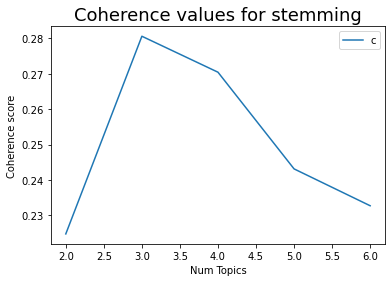

... Running lda with 3 topics
=== LDA model with 3 topics took : 0.23 minutes
Topic: 0 -> Words: 0.024*"arme" + 0.022*"macron" + 0.020*"plus" + 0.015*"russ" + 0.015*"ete" + 0.013*"pay" + 0.012*"kiev" + 0.012*"depuis" + 0.011*"otan" + 0.009*"faut"
Topic: 1 -> Words: 0.032*"franc" + 0.016*"tout" + 0.016*"europ" + 0.015*"europeen" + 0.015*"ue" + 0.010*"soutien" + 0.009*"emmanuelmacron" + 0.008*"situat" + 0.008*"etre" + 0.008*"aid"
Topic: 2 -> Words: 0.029*"ukrainien" + 0.017*"poutin" + 0.015*"contr" + 0.013*"zelensky" + 0.013*"fait" + 0.011*"president" + 0.011*"comm" + 0.009*"apre" + 0.008*"parl" + 0.008*"fair"
=== Coherence Score: 0.28
... Running lda visualization
... Running dominant topics
Format topics took 1.1e+01 minutes

 Total running time: 14.223484710852306 minutes


In [44]:
run_all(data["text_stem"], "stemming", True)

===== Method : bigramLemmatization =====
... Running bag of words 
... Running search for best nb of topics
=== LDA model with 2 topics took : 0.16 minutes
Topic: 0 -> Words: 0.020*"emmanuel_macron" + 0.016*"vladimir_poutine" + 0.015*"point_situation" + 0.012*"mieux_comprendre" + 0.012*"retrouvez_toutes" + 0.012*"toutes_information" + 0.012*"comprendre_enjeu" + 0.012*"depuis_debut" + 0.011*"information_mieux" + 0.011*"enjeu_crise"
Topic: 1 -> Words: 0.019*"union_europeenne" + 0.014*"statut_candidat" + 0.012*"volodymyr_zelensky" + 0.009*"armee_ukrainien" + 0.009*"centre_commercial" + 0.008*"frederic_leclerc" + 0.008*"leclerc_imhoff" + 0.007*"suivez_direct" + 0.007*"mer_noire" + 0.006*"apres_avoir"
=== Coherence Score: 0.62
=== LDA model with 3 topics took : 0.17 minutes
Topic: 0 -> Words: 0.014*"peuple_ukrainien" + 0.012*"reseaux_sociaux" + 0.012*"doit_etre" + 0.012*"accord_minsk" + 0.012*"armee_ukrainien" + 0.012*"affaire_etrangeres" + 0.011*"force_russe" + 0.011*"etats_uni" + 0.010*"c

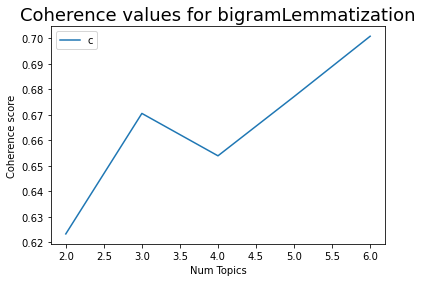

... Running lda with 6 topics
=== LDA model with 6 topics took : 0.18 minutes
Topic: 0 -> Words: 0.057*"centre_commercial" + 0.030*"doit_etre" + 0.029*"affaire_etrangeres" + 0.027*"etats_uni" + 0.024*"situation_militaire" + 0.021*"lopinion_fr" + 0.020*"moins_mort" + 0.018*"militaire_juin" + 0.017*"ministre_affaire" + 0.016*"parlement_europeen"
Topic: 1 -> Words: 0.061*"statut_candidat" + 0.055*"union_europeenne" + 0.035*"volodymyr_zelensky" + 0.025*"candidat_ue" + 0.025*"mettre_abri" + 0.024*"faut_mettre" + 0.020*"carte_situation" + 0.017*"sommet_otan" + 0.016*"pro_russe" + 0.015*"force_ru"
Topic: 2 -> Words: 0.027*"armee_ukrainien" + 0.020*"president_emmanuelmacron" + 0.019*"apres_avoir" + 0.016*"frappe_missile" + 0.016*"pro_poutine" + 0.015*"ete_tue" + 0.015*"apres_moi" + 0.014*"frappe_russe" + 0.013*"president_ukrainien" + 0.013*"apres_midi"
Topic: 3 -> Words: 0.044*"emmanuel_macron" + 0.035*"vladimir_poutine" + 0.035*"point_situation" + 0.027*"mieux_comprendre" + 0.026*"retrouvez_t

KeyboardInterrupt: 

In [46]:
run_all(data["text_lemma_bigrame"], "bigramLemmatization", True)

In [47]:
run_all(data["text_lemma_bigrame"], "bigramLemmatization", False, 3)

===== Method : bigramLemmatization =====
... Running bag of words 
... Running lda with 3 topics
=== LDA model with 3 topics took : 0.16 minutes
Topic: 0 -> Words: 0.014*"peuple_ukrainien" + 0.012*"reseaux_sociaux" + 0.012*"doit_etre" + 0.012*"accord_minsk" + 0.012*"armee_ukrainien" + 0.012*"affaire_etrangeres" + 0.011*"force_russe" + 0.011*"etats_uni" + 0.010*"carte_situation" + 0.010*"situation_militaire"
Topic: 1 -> Words: 0.032*"statut_candidat" + 0.029*"union_europeenne" + 0.017*"centre_commercial" + 0.013*"mettre_abri" + 0.013*"faut_mettre" + 0.011*"candidat_ue" + 0.011*"canon_caesar" + 0.009*"quelques_jour" + 0.009*"moins_mort" + 0.009*"sommet_otan"
Topic: 2 -> Words: 0.031*"emmanuel_macron" + 0.024*"vladimir_poutine" + 0.024*"point_situation" + 0.019*"mieux_comprendre" + 0.019*"depuis_debut" + 0.019*"retrouvez_toutes" + 0.019*"toutes_information" + 0.019*"comprendre_enjeu" + 0.019*"information_mieux" + 0.019*"crise_notredefense"
=== Coherence Score: 0.67
... Running lda visuali

In [51]:
run_all(data["text_stem_bigrame"], "bigramStemming",  False, 4)

===== Method : bigramStemming =====
... Running bag of words 
... Running lda with 4 topics
=== LDA model with 4 topics took : 0.17 minutes
Topic: 0 -> Words: 0.026*"point_situat" + 0.020*"mieux_comprendr" + 0.020*"depuis_debut" + 0.020*"tout_inform" + 0.020*"retrouv_tout" + 0.020*"comprendr_enjeux" + 0.020*"enjeux_cris" + 0.020*"cris_notredefens" + 0.020*"inform_mieux" + 0.020*"armeedeterr_arme"
Topic: 1 -> Words: 0.022*"centr_commercial" + 0.016*"reseau_social" + 0.016*"accord_minsk" + 0.014*"canon_caesar" + 0.014*"forc_russ" + 0.014*"etat_unis" + 0.013*"ete_tu" + 0.012*"mer_noir" + 0.012*"suiv_direct" + 0.012*"ile_serpent"
Topic: 2 -> Words: 0.035*"statut_candidat" + 0.032*"union_europeen" + 0.018*"arme_ukrainien" + 0.015*"doit_etre" + 0.014*"mettr_abri" + 0.014*"faut_mettr" + 0.014*"candidat_ue" + 0.012*"cart_situat" + 0.011*"situat_militair" + 0.011*"militair_juin"
Topic: 3 -> Words: 0.046*"emmanuel_macron" + 0.036*"vladim_poutin" + 0.027*"volodymyr_zelensky" + 0.022*"peupl_ukrain

===== Method : trigramLemmatization =====
... Running bag of words 
... Running search for best nb of topics
=== LDA model with 2 topics took : 0.11 minutes
Topic: 0 -> Words: 0.095*"frederic_leclerc_imhoff" + 0.051*"carte_situation_militaire" + 0.051*"situation_militaire_juin" + 0.046*"militaire_juin_soir" + 0.046*"juin_soir_donbass" + 0.032*"adhesion_union_europeenne" + 0.031*"ministre_affaire_etrangeres" + 0.029*"von_der_leyen" + 0.026*"crime_contre_humanite" + 0.024*"ursula_von_der"
Topic: 1 -> Words: 0.050*"retrouvez_toutes_information" + 0.050*"toutes_information_mieux" + 0.050*"information_mieux_comprendre" + 0.050*"enjeu_crise_notredefense" + 0.050*"comprendre_enjeu_crise" + 0.050*"mieux_comprendre_enjeu" + 0.049*"armee_lair_marinenationale" + 0.049*"situation_retrouvez_toutes" + 0.049*"armeedeterre_armee_lair" + 0.049*"point_situation_retrouvez"
=== Coherence Score: 0.73
=== LDA model with 3 topics took : 0.12 minutes
Topic: 0 -> Words: 0.202*"frederic_leclerc_imhoff" + 0.067*

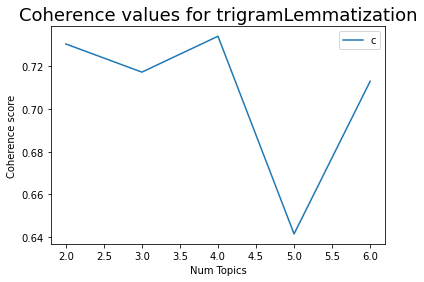

... Running lda with 4 topics
=== LDA model with 4 topics took : 0.12 minutes
Topic: 0 -> Words: 0.067*"adhesion_union_europeenne" + 0.061*"von_der_leyen" + 0.051*"ursula_von_der" + 0.049*"cet_apres_midi" + 0.046*"via_lopinion_fr" + 0.039*"apres_avoir_ete" + 0.031*"president_volodymyr_zelensky" + 0.031*"eme_jour_invasion" + 0.028*"toulouse_montpellier_herault" + 0.028*"montpellier_herault_beziers"
Topic: 1 -> Words: 0.130*"carte_situation_militaire" + 0.130*"situation_militaire_juin" + 0.117*"militaire_juin_soir" + 0.117*"juin_soir_donbass" + 0.048*"secretaire_general_otan" + 0.039*"soutien_peuple_ukrainien" + 0.037*"vice_premiere_ministre" + 0.036*"crise_alimentaire_mondiale" + 0.031*"securite_alimentaire_mondiale" + 0.021*"prix_nobel_paix"
Topic: 2 -> Words: 0.059*"retrouvez_toutes_information" + 0.059*"comprendre_enjeu_crise" + 0.059*"enjeu_crise_notredefense" + 0.059*"information_mieux_comprendre" + 0.059*"mieux_comprendre_enjeu" + 0.059*"toutes_information_mieux" + 0.057*"armeedet

In [52]:
run_all(data["text_lemma_trigrame"], "trigramLemmatization", True)

===== Method : trigramStemming =====
... Running bag of words 
... Running search for best nb of topics
=== LDA model with 2 topics took : 0.11 minutes
Topic: 0 -> Words: 0.092*"frederic_leclerc_imhoff" + 0.049*"cart_situat_militair" + 0.049*"situat_militair_juin" + 0.044*"militair_juin_soir" + 0.044*"juin_soir_donbass" + 0.031*"adhes_union_europeen" + 0.030*"ministr_affair_etranger" + 0.028*"von_der_leyen" + 0.026*"crim_contr_humanit" + 0.024*"ursul_von_der"
Topic: 1 -> Words: 0.049*"retrouv_tout_inform" + 0.049*"inform_mieux_comprendr" + 0.049*"comprendr_enjeux_cris" + 0.049*"enjeux_cris_notredefens" + 0.049*"tout_inform_mieux" + 0.049*"mieux_comprendr_enjeux" + 0.048*"situat_retrouv_tout" + 0.048*"armeedeterr_arme_lair" + 0.048*"arme_lair_marinenational" + 0.048*"point_situat_retrouv"
=== Coherence Score: 0.74
=== LDA model with 3 topics took : 0.12 minutes
Topic: 0 -> Words: 0.191*"frederic_leclerc_imhoff" + 0.062*"ministr_affair_etranger" + 0.059*"von_der_leyen" + 0.049*"ursul_von

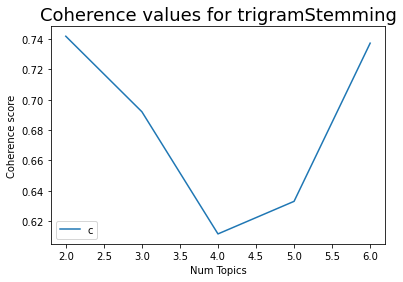

... Running lda with 2 topics
=== LDA model with 2 topics took : 0.12 minutes
Topic: 0 -> Words: 0.092*"frederic_leclerc_imhoff" + 0.049*"cart_situat_militair" + 0.049*"situat_militair_juin" + 0.044*"militair_juin_soir" + 0.044*"juin_soir_donbass" + 0.031*"adhes_union_europeen" + 0.030*"ministr_affair_etranger" + 0.028*"von_der_leyen" + 0.026*"crim_contr_humanit" + 0.024*"ursul_von_der"
Topic: 1 -> Words: 0.049*"retrouv_tout_inform" + 0.049*"inform_mieux_comprendr" + 0.049*"comprendr_enjeux_cris" + 0.049*"enjeux_cris_notredefens" + 0.049*"tout_inform_mieux" + 0.049*"mieux_comprendr_enjeux" + 0.048*"situat_retrouv_tout" + 0.048*"armeedeterr_arme_lair" + 0.048*"arme_lair_marinenational" + 0.048*"point_situat_retrouv"
=== Coherence Score: 0.74
... Running lda visualization
... Running dominant topics
Format topics took 9.8 minutes

 Total running time: 11.09171293179194 minutes


In [53]:
run_all(data["text_stem_trigrame"], "trigramStemming", True)

In [54]:
run_all(data["text_stem_trigrame"], "trigramStemming", False, 3)

===== Method : trigramStemming =====
... Running bag of words 
... Running lda with 3 topics
=== LDA model with 3 topics took : 0.11 minutes
Topic: 0 -> Words: 0.191*"frederic_leclerc_imhoff" + 0.062*"ministr_affair_etranger" + 0.059*"von_der_leyen" + 0.049*"ursul_von_der" + 0.048*"cet_apre_mid" + 0.045*"vi_lopinion_fr" + 0.037*"apre_avoir_ete" + 0.033*"plac_republ_paris" + 0.032*"respect_accord_minsk" + 0.030*"president_volodymyr_zelensky"
Topic: 1 -> Words: 0.074*"cart_situat_militair" + 0.074*"situat_militair_juin" + 0.067*"militair_juin_soir" + 0.067*"juin_soir_donbass" + 0.047*"adhes_union_europeen" + 0.040*"depuis_debut_confl" + 0.032*"appliqu_accord_minsk" + 0.028*"secretair_general_otan" + 0.022*"soutien_peupl_ukrainien" + 0.022*"eme_jour_invas"
Topic: 2 -> Words: 0.055*"retrouv_tout_inform" + 0.055*"enjeux_cris_notredefens" + 0.055*"comprendr_enjeux_cris" + 0.055*"tout_inform_mieux" + 0.055*"inform_mieux_comprendr" + 0.055*"mieux_comprendr_enjeux" + 0.053*"arme_lair_marinenati

In [95]:


test = pd.read_csv("output/dominant_topics_lemma.csv", sep=";")
test.drop("Unnamed: 0", axis=1, inplace=True)

In [57]:
test.head()

Unnamed: 0  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0           0            0               1              0.7093   
1           1            1               1              0.8374   
2           2            2               1              0.9216   
3           3            3               1              0.7627   
4           4            4               1              0.6598   

                                            Keywords  \
0  france, poutine, macron, europe, ue, plus, con...   
1  france, poutine, macron, europe, ue, plus, con...   
2  france, poutine, macron, europe, ue, plus, con...   
3  france, poutine, macron, europe, ue, plus, con...   
4  france, poutine, macron, europe, ue, plus, con...   

                                                Text  
0  ['info', 'malheureusement', 'tres', 'peu', 're...  
1            ['face', 'poutine', 'macron', 'hausse']  
2  ['crise', 'emmanuel', 'macron', 'vladimir', 'p...  
3  ['equivalent', 'pib', 'italie', 'attention', '...  
4  ['crise', 'pourquoi', 'faut', 'sortir', 'piege...

In [104]:
def representative_sentence(df_topic):
    
    sort_rep_topic = df_topic.sort_values(
        by=["Dominant_Topic", "Topic_Perc_Contrib"],
        ascending=[True,False])
    sort_rep_topic = sort_rep_topic.drop_duplicates(["Dominant_Topic"])
    
    # Format
    sort_rep_topic.columns = ["tweet_no", "dominant_topic",
                              "topic_perc_contrib",
                              "keywords", "representative_text"]
   
    for i, row in sort_rep_topic.iterrows():
        print(f"Topic number: {row['dominant_topic']}")
        print(row["representative_text"])
    
    return sort_rep_topic

In [105]:
representative_sentence(test)

Topic number:0 
['nouvelle', 'frappe', 'russe', 'vise', 'nuit', 'base', 'militaire', 'pres', 'frontiere', 'polonaise', 'faisant', 'moins', 'mort', 'selon', 'autorites', 'locale', 'tandis', 'pres', 'kiev', 'journaliste', 'americain', 'ete', 'tue', 'balle', 'afp', 'afpgraphics']
Topic number:1 
['encore', 'conflit', 'francais', 'devront', 'boire', 'parole', 'president', 'sans', 'dire', 'mot', 'volonte', 'etre', 'syrie', 'libye', 'mali', 'sahel', 'yemen', 'toutes', 'guerre', 'france', 'engage', 'sans', 'peuple', 'sans', 'parlement', 'sans', 'intelligence']


tweet_no  dominant_topic  topic_perc_contrib  \
11591     11591               0              0.9345   
425         425               1              0.9599   

                                                keywords  \
11591  ukrainien, russe, ete, kiev, armee, jour, arme...   
425    france, poutine, macron, europe, ue, plus, con...   

                                     representative_text  
11591  ['nouvelle', 'frappe', 'russe', 'vise', 'nuit'...  
425    ['encore', 'conflit', 'francais', 'devront', '...

0        Unnamed: 0  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
5               5            5               0              0.5273   
16             16           16               0              0.6544   
20             20           20               0              0.5751   
37             37           37               0              0.5154   
39             39           39               0              0.6032   
...           ...          ...             ...                 ...   
19707       19707        19707               0              0.6629   
19711       19711        19711               0              0.6021   
19714       19714        19714               0              0.5857   
19718       19718        19718               0              0.7911   
19729       19729        19729               0              0.8878   

                                                Keywords  \
5      ukrainien, russe, ete, kiev, armee, jour, arme...   
16     ukrainien, russe, ete, kiev, a

In [30]:
#text_tokens_lemma, dico_words_lemma, doc_term_matrix_lemma = compute_bag_of_words(data["text_lemma"])
#best_topics_lemma = search_nb_topics(dictionary=dico_words_lemma,
#                                    corpus=doc_term_matrix_lemma,
#                                    texts=text_tokens_lemma,
#                                    start=2, limit=7, step=1)


lda_lemma, score_lemma = compute_lda(dictionary=dico_words_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma, num_topics=3)


vis = gensimvis.prepare(topic_model=lda_lemma, corpus=doc_term_matrix_lemma, dictionary=dico_words_lemma)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_lemma.html')



Model took : 0.19 minutes
Topic: 0 -> Words: 0.045*"russie" + 0.039*"russe" + 0.017*"france" + 0.017*"plus" + 0.014*"ete" + 0.012*"macron" + 0.012*"pays" + 0.011*"zelensky" + 0.011*"arme" + 0.011*"president"
Topic: 1 -> Words: 0.030*"ukrainien" + 0.012*"contre" + 0.010*"armee" + 0.009*"europe" + 0.009*"force" + 0.009*"jour" + 0.008*"situation" + 0.008*"soutien" + 0.008*"civil" + 0.007*"hui"
Topic: 2 -> Words: 0.055*"guerre" + 0.028*"poutine" + 0.010*"fait" + 0.009*"tout" + 0.009*"etre" + 0.008*"comme" + 0.008*"faire" + 0.008*"tous" + 0.007*"paix" + 0.007*"francais"

Coherence Score: 0.32


/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/mamba/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload




Model took : 0.21 minutes
Topic: 0 -> Words: 0.030*"guerr" + 0.023*"russ" + 0.015*"poutin" + 0.012*"franc" + 0.010*"plus" + 0.010*"tout" + 0.007*"macron" + 0.007*"europ" + 0.007*"contr" + 0.006*"europeen"
Topic: 1 -> Words: 0.037*"russ" + 0.024*"ukrainien" + 0.017*"arme" + 0.012*"ete" + 0.008*"direct" + 0.008*"kiev" + 0.007*"forc" + 0.006*"mai" + 0.006*"guerr" + 0.006*"marioupol"

Coherence Score: 0.35


Model took : 0.18 minutes
Topic: 0 -> Words: 0.052*"guerr" + 0.022*"poutin" + 0.018*"plus" + 0.016*"russ" + 0.016*"franc" + 0.012*"contr" + 0.011*"macron" + 0.008*"fait" + 0.008*"comm" + 0.007*"etre"
Topic: 1 -> Words: 0.041*"russ" + 0.037*"ukrainien" + 0.027*"arme" + 0.019*"ete" + 0.012*"kiev" + 0.010*"forc" + 0.009*"marioupol" + 0.009*"civil" + 0.008*"apre" + 0.008*"jour"
Topic: 2 -> Words: 0.034*"russ" + 0.012*"europ" + 0.012*"president" + 0.011*"europeen" + 0.011*"zelensky" + 0.009*"mai" + 0.009*"aid" + 0.008*"tout" + 0.008*"direct" + 0.008*"pay"

Coherence Score: 0.35


Model to

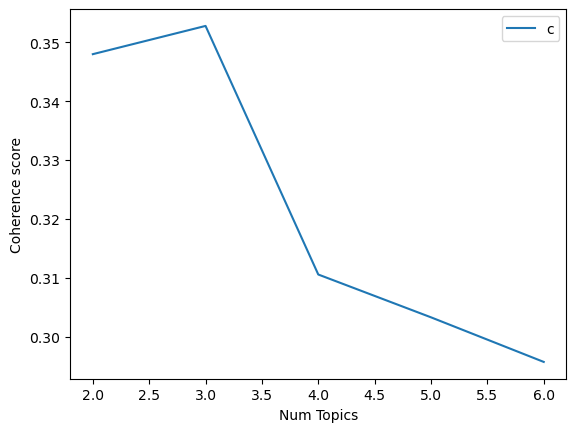



Model took : 0.17 minutes
Topic: 0 -> Words: 0.052*"guerr" + 0.022*"poutin" + 0.018*"plus" + 0.016*"russ" + 0.016*"franc" + 0.012*"contr" + 0.011*"macron" + 0.008*"fait" + 0.008*"comm" + 0.007*"etre"
Topic: 1 -> Words: 0.041*"russ" + 0.037*"ukrainien" + 0.027*"arme" + 0.019*"ete" + 0.012*"kiev" + 0.010*"forc" + 0.009*"marioupol" + 0.009*"civil" + 0.008*"apre" + 0.008*"jour"
Topic: 2 -> Words: 0.034*"russ" + 0.012*"europ" + 0.012*"president" + 0.011*"europeen" + 0.011*"zelensky" + 0.009*"mai" + 0.009*"aid" + 0.008*"tout" + 0.008*"direct" + 0.008*"pay"

Coherence Score: 0.35


/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [31]:
# stem
text_tokens_stem, dico_words_stem, doc_term_matrix_stem = compute_bag_of_words(data["text_stem"])
best_topics_stem = search_nb_topics(dictionary=dico_words_stem,
                                    corpus=doc_term_matrix_stem,
                                    texts=text_tokens_stem,
                                    start=2, limit=7, step=1)

lda_stem, score_stem = compute_lda(dictionary=dico_words_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem, num_topics=best_topics_stem)


vis = gensimvis.prepare(topic_model=lda_stem, corpus=doc_term_matrix_stem, dictionary=dico_words_stem)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem.html')

In [34]:
# bigrammes
text_tokens_bigram, dico_words_bigram, doc_term_matrix_bigram = compute_bag_of_words(data["text_lemma_bigrame"])

#best_topics_bigram = search_nb_topics(dictionary=dico_words_bigram,
#                                                        corpus=doc_term_matrix_bigram,
#                                                        texts=text_tokens_bigram,
#                                                        start=2, limit=10, step=1)

lda_bigram, score_bigram = compute_lda(dictionary=dico_words_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram, num_topics=5)

vis = gensimvis.prepare(topic_model=lda_bigram, corpus=doc_term_matrix_bigram, dictionary=dico_words_bigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_bigram.html')



Model took : 0.14 minutes
Topic: 0 -> Words: 0.171*"guerre_ukraine" + 0.059*"ukraine_russie" + 0.018*"direct_guerre" + 0.015*"etats_uni" + 0.010*"ukraine_president" + 0.010*"poutine_ukraine" + 0.008*"armee_ukrainien" + 0.007*"peut_etre" + 0.007*"parlement_europeen" + 0.006*"soldat_ukrainien"
Topic: 1 -> Words: 0.025*"guerre_mondiale" + 0.021*"conflit_ukraine" + 0.020*"contre_ukraine" + 0.017*"soutien_ukraine" + 0.015*"depuis_debut" + 0.012*"guerre_contre" + 0.011*"standwithukraine_ukraine" + 0.011*"plus_plus" + 0.011*"debut_guerre" + 0.010*"russie_poutine"
Topic: 2 -> Words: 0.028*"situation_ukraine" + 0.024*"armee_russe" + 0.021*"point_situation" + 0.020*"mieux_comprendre" + 0.020*"ukraine_retrouvez" + 0.018*"armee_lair" + 0.018*"armeedeterre_armee" + 0.018*"comprendre_enjeu" + 0.018*"retrouvez_toutes" + 0.018*"toutes_information"
Topic: 3 -> Words: 0.052*"russie_ukraine" + 0.030*"peuple_ukrainien" + 0.020*"contre_russie" + 0.014*"agression_russe" + 0.014*"affaire_etrangeres" + 0.01

/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/mamba/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [36]:
# bigramms with stemmatization
text_tokens_stem_bigram, dico_words_stem_bigram, doc_term_matrix_stem_bigram = compute_bag_of_words(data["text_stem_bigrame"])

#best_topics_stem_bigram = search_nb_topics(dictionary=dico_words_stem_bigram,
#                                                        corpus=doc_term_matrix_stem_bigram,
#                                                        texts=text_tokens_stem_bigram,
#                                                        start=2, limit=10, step=1)

lda_stem_bigram, score_stem_bigram = compute_lda(dictionary=dico_words_stem_bigram, corpus=doc_term_matrix_stem_bigram, texts=text_tokens_stem_bigram, num_topics=3)

vis = gensimvis.prepare(topic_model=lda_stem_bigram, corpus=doc_term_matrix_stem_bigram, dictionary=dico_words_stem_bigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem_bigram.html')



Model took : 0.17 minutes
Topic: 0 -> Words: 0.092*"guerr_ukrain" + 0.033*"ukrain_russ" + 0.018*"vladim_poutin" + 0.013*"situat_ukrain" + 0.010*"ukrain_retrouv" + 0.010*"point_situat" + 0.010*"direct_guerr" + 0.009*"mieux_comprendr" + 0.009*"arme_lair" + 0.009*"armeedeterr_arme"
Topic: 1 -> Words: 0.046*"russ_ukrain" + 0.028*"aujourd_hui" + 0.015*"arme_russ" + 0.012*"crim_guerr" + 0.010*"confl_ukrain" + 0.010*"etat_unis" + 0.010*"contr_ukrain" + 0.009*"arme_ukrain" + 0.009*"guerr_russ" + 0.009*"soutien_ukrain"
Topic: 2 -> Words: 0.019*"peupl_ukrainien" + 0.017*"guerr_mondial" + 0.010*"depuis_debut" + 0.009*"president_ukrainien" + 0.009*"affair_etranger" + 0.009*"poutin_ukrain" + 0.007*"serguei_lavrov" + 0.007*"debut_guerr" + 0.007*"russ_poutin" + 0.007*"aid_militair"

Coherence Score: 0.49


/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/mamba/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload




Model took : 0.12 minutes
Topic: 0 -> Words: 0.058*"direct_guerre_ukraine" + 0.031*"frederic_leclerc_imhoff" + 0.023*"guerre_ukraine_russie" + 0.018*"eme_guerre_mondiale" + 0.016*"troisieme_guerre_mondiale" + 0.015*"secretaire_general_onu" + 0.015*"contexte_guerre_ukraine" + 0.015*"cet_apres_midi" + 0.013*"conseil_securite_onu" + 0.013*"place_republique_pari"
Topic: 1 -> Words: 0.040*"point_situation_ukraine" + 0.038*"retrouvez_toutes_information" + 0.038*"comprendre_enjeu_crise" + 0.038*"information_mieux_comprendre" + 0.038*"toutes_information_mieux" + 0.038*"mieux_comprendre_enjeu" + 0.038*"enjeu_crise_notredefense" + 0.038*"ukraine_retrouvez_toutes" + 0.038*"situation_ukraine_retrouvez" + 0.038*"armee_lair_marinenationale"

Coherence Score: 0.75


Model took : 0.12 minutes
Topic: 0 -> Words: 0.126*"direct_guerre_ukraine" + 0.055*"frederic_leclerc_imhoff" + 0.027*"russe_affaire_etrangeres" + 0.025*"debut_guerre_ukraine" + 0.025*"force_russe_ukraine" + 0.024*"ukraine_vladimir_pouti

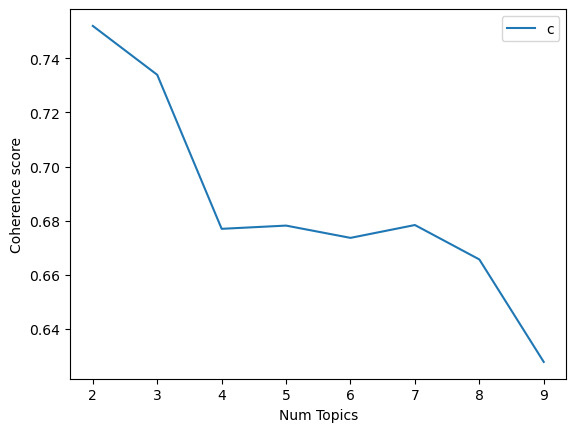



Model took : 0.12 minutes
Topic: 0 -> Words: 0.058*"direct_guerre_ukraine" + 0.031*"frederic_leclerc_imhoff" + 0.023*"guerre_ukraine_russie" + 0.018*"eme_guerre_mondiale" + 0.016*"troisieme_guerre_mondiale" + 0.015*"secretaire_general_onu" + 0.015*"contexte_guerre_ukraine" + 0.015*"cet_apres_midi" + 0.013*"conseil_securite_onu" + 0.013*"place_republique_pari"
Topic: 1 -> Words: 0.040*"point_situation_ukraine" + 0.038*"retrouvez_toutes_information" + 0.038*"comprendre_enjeu_crise" + 0.038*"information_mieux_comprendre" + 0.038*"toutes_information_mieux" + 0.038*"mieux_comprendre_enjeu" + 0.038*"enjeu_crise_notredefense" + 0.038*"ukraine_retrouvez_toutes" + 0.038*"situation_ukraine_retrouvez" + 0.038*"armee_lair_marinenationale"

Coherence Score: 0.75


/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/mamba/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [39]:
# trigrames
text_tokens_trigram, dico_words_trigram, doc_term_matrix_trigram = compute_bag_of_words(data["text_lemma_trigrame"])

best_topics_trigram = search_nb_topics(dictionary=dico_words_trigram,
                                                        corpus=doc_term_matrix_trigram,
                                                        texts=text_tokens_trigram,
                                                        start=2, limit=10, step=1)

lda_trigram, score_trigram = compute_lda(dictionary=dico_words_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram, num_topics=best_topics_trigram)

vis = gensimvis.prepare(topic_model=lda_trigram, corpus=doc_term_matrix_trigram, dictionary=dico_words_trigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_trigram.html')



Model took : 0.14 minutes
Topic: 0 -> Words: 0.029*"frederic_leclerc_imhoff" + 0.022*"guerr_ukrain_russ" + 0.019*"depuis_debut_guerr" + 0.017*"eme_guerr_mondial" + 0.016*"minister_russ_defens" + 0.015*"troisiem_guerr_mondial" + 0.015*"context_guerr_ukrain" + 0.015*"secretair_general_onu" + 0.012*"conseil_securit_onu" + 0.012*"russ_affair_etranger"
Topic: 1 -> Words: 0.041*"direct_guerr_ukrain" + 0.037*"point_situat_ukrain" + 0.036*"retrouv_tout_inform" + 0.036*"tout_inform_mieux" + 0.036*"enjeux_cris_notredefens" + 0.036*"comprendr_enjeux_cris" + 0.036*"inform_mieux_comprendr" + 0.036*"mieux_comprendr_enjeux" + 0.035*"situat_ukrain_retrouv" + 0.035*"arme_lair_marinenational"

Coherence Score: 0.76


Model took : 0.15 minutes
Topic: 0 -> Words: 0.034*"guerr_ukrain_russ" + 0.030*"depuis_debut_guerr" + 0.026*"eme_guerr_mondial" + 0.024*"troisiem_guerr_mondial" + 0.023*"cet_apre_mid" + 0.021*"consequent_guerr_ukrain" + 0.019*"russ_affair_etranger" + 0.017*"debut_guerr_ukrain" + 0.017*"fo

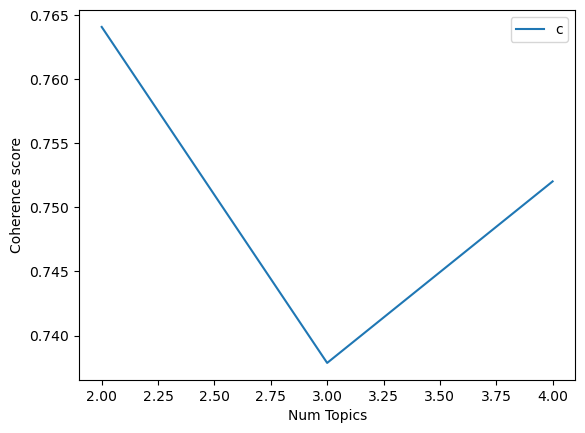



Model took : 0.14 minutes
Topic: 0 -> Words: 0.029*"frederic_leclerc_imhoff" + 0.022*"guerr_ukrain_russ" + 0.019*"depuis_debut_guerr" + 0.017*"eme_guerr_mondial" + 0.016*"minister_russ_defens" + 0.015*"troisiem_guerr_mondial" + 0.015*"context_guerr_ukrain" + 0.015*"secretair_general_onu" + 0.012*"conseil_securit_onu" + 0.012*"russ_affair_etranger"
Topic: 1 -> Words: 0.041*"direct_guerr_ukrain" + 0.037*"point_situat_ukrain" + 0.036*"retrouv_tout_inform" + 0.036*"tout_inform_mieux" + 0.036*"enjeux_cris_notredefens" + 0.036*"comprendr_enjeux_cris" + 0.036*"inform_mieux_comprendr" + 0.036*"mieux_comprendr_enjeux" + 0.035*"situat_ukrain_retrouv" + 0.035*"arme_lair_marinenational"

Coherence Score: 0.76


/opt/mamba/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [63]:
# trigrames stem
text_tokens_stem_trigram, dico_words_stem_trigram, doc_term_matrix_stem_trigram = compute_bag_of_words(data["text_stem_trigrame"])

best_topics_stem_trigram = search_nb_topics(dictionary=dico_words_stem_trigram,
                                                        corpus=doc_term_matrix_stem_trigram,
                                                        texts=text_tokens_stem_trigram,
                                                        start=2, limit=5, step=1)

lda_stem_trigram, score_stem_trigram = compute_lda(dictionary=dico_words_stem_trigram, corpus=doc_term_matrix_stem_trigram, texts=text_tokens_stem_trigram, num_topics=best_topics_stem_trigram)

vis = gensimvis.prepare(topic_model=lda_stem_trigram, corpus=doc_term_matrix_stem_trigram, dictionary=dico_words_stem_trigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem_trigram.html')

# Assign a topic to each tweet 

In [59]:
# Assign a topic to each tweet 
def format_topics_sentences(ldamodel, corpus, texts):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        start = time.time()
        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            # per_word_topics: list of topics, sorted in descending order of most likely topics for each word
            row = row_list[0] if ldamodel.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        end = time.time()
        delta = (end - start)/60
        print(f"Took {delta:.2} minutes")
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        
        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

        # format
        sent_topics_df = sent_topics_df.reset_index()
        sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        return(sent_topics_df)

def make_cloud(df, df_dominant_topic, vect_type):
    df[f"Dominant_Topic_{vect_type}"] = df_dominant_topic["Dominant_Topic"]
    color_list = ["summer", "winter", "Oranges", "seismic"]
    
    for i in df_dominant_topic["Dominant_Topic"].unique():
        color = random.choice(color_list)
        cloud = WordCloud(colormap=color, width=800, height=400).generate(str(
            df[df[f"Dominant_Topic_{vect_type}"]==i][f"text_{vect_type}"]))
        fig = plt.figure(figsize=(12,10))
        plt.axis("off")
        plt.imshow(cloud,interpolation='bilinear')
        plt.title(f"WordCloud for Topic {i}", size = 24)
        plt.show()

        cloud.to_file(f"output/img/{vect_type}_topic{i}.png")

In [65]:
df_dominant_topics_lemma.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               0              0.4624   
1            1               1              0.4406   
2            2               1              0.5767   
3            3               2              0.4858   
4            4               2              0.6251   

                                            Keywords  \
0  russie, russe, france, plus, ete, macron, pays...   
1  ukrainien, contre, armee, europe, force, jour,...   
2  ukrainien, contre, armee, europe, force, jour,...   
3  guerre, poutine, fait, tout, etre, comme, fair...   
4  guerre, poutine, fait, tout, etre, comme, fair...   

                                                Text  
0  [espagne, mincolonna, recu, homologue, jmalbar...  
1  [ukraine, faut, savoir, matin, juin, jour, gue...  
2  [ukraine, point, situation, aujourd, hui, invi...  
3  [epingle, checknewsfr, mensonge, propos, voyag...  
4  [adrien, bocquet, menti, voyage, ukraine, ment...

In [64]:
df_dominant_topics_lemma = format_topics_sentences(ldamodel=lda_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma)
df_dominant_topics_stem = format_topics_sentences(ldamodel=lda_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem)
df_dominant_topics_bigrame = format_topics_sentences(ldamodel=lda_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram)
df_dominant_topics_trigram = format_topics_sentences(ldamodel=lda_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram)
df_dominant_topics_stem_bigrame = format_topics_sentences(ldamodel=lda_stem_bigram, corpus=doc_term_matrix_stem_bigram, texts=text_tokens_stem_bigram)
df_dominant_topics_stem_trigram = format_topics_sentences(ldamodel=lda_stem_trigram, corpus=doc_term_matrix_stem_trigram, texts=text_tokens_stem_trigram)

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.8 minutes


/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.76 minutes


/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.67 minutes


/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.63 minutes


/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.75 minutes


/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3464/2074452855.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Took 0.64 minutes


In [ ]:
all_files = [df_dominant_topics_lemma, df_dominant_topics_stem, df_dominant_topics_bigrame,
            df_dominant_topics_trigram,  df_dominant_topics_stem_bigrame, df_dominant_topics_stem_trigram]
for i,file in enumerate(all_files):
    file.to_csv(f"output/{i}.csv", sep=";")

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0                0               0              0.4624   
1                1               1              0.4406   
2                2               1              0.5767   
3                3               2              0.4858   
4                4               2              0.6251   
...            ...             ...                 ...   
19744        19744               2              0.3812   
19745        19745               1              0.6280   
19746        19746               0              0.5134   
19747        19747               2              0.5188   
19748        19748               0              0.3909   

                                                Keywords  \
0      russie, russe, france, plus, ete, macron, pays...   
1      ukrainien, contre, armee, europe, force, jour,...   
2      ukrainien, contre, armee, europe, force, jour,...   
3      guerre, poutine, fait, tout, etre, comme, fair...   
4      guerre, poutine, fait, tout, etre, comme, fair...   
...                                                  ...   
19744  guerre, poutine, fait, tout, etre, comme, fair...   
19745  ukrainien, contre, armee, europe, force, jour,...   
19746  russie, russe, france, plus, ete, macron, pays...   
19747  guerre, poutine, fait, tout, etre, comme, fair...   
19748  russie, russe, france, plus, ete, macron, pays...   

                                                    Text  
0      [espagne, mincolonna, recu, homologue, jmalbar...  
1      [ukraine, faut, savoir, matin, juin, jour, gue...  
2      [ukraine, point, situation, aujourd, hui, invi...  
3      [epingle, checknewsfr, mensonge, propos, voyag...  
4      [adrien, bocquet, menti, voyage, ukraine, ment...  
...                                                  ...  
19744  [demande, quoi, sert, twitter, er, debut, covi...  
19745  [ukraine, autour, kharkiv, contre, offensive, ...  
19746  [direct, guerre, ukraine, onu, lance, enquete,...  
19747  [choque, europe, donne, argent, militaire, neo...  
19748  [russie, exige, reunion, publique, conseil, se...  

[19749 rows x 5 columns]

/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

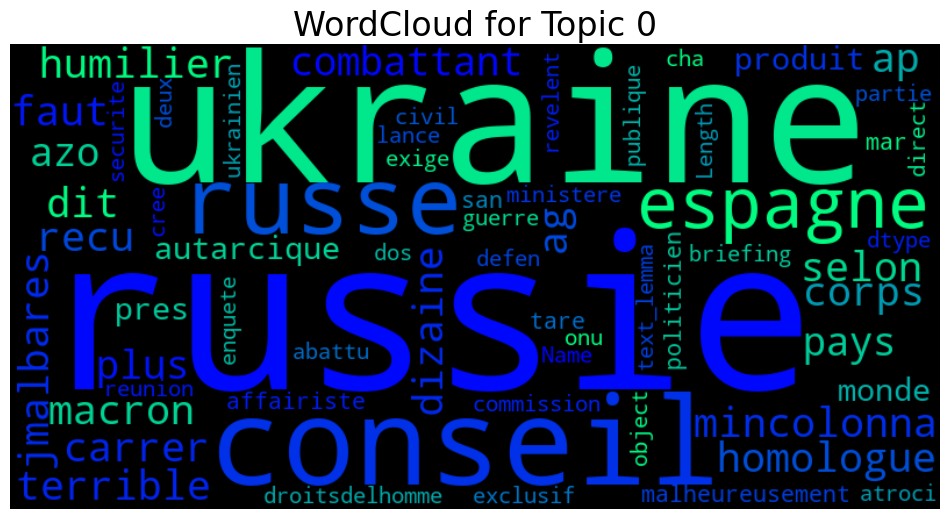

/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

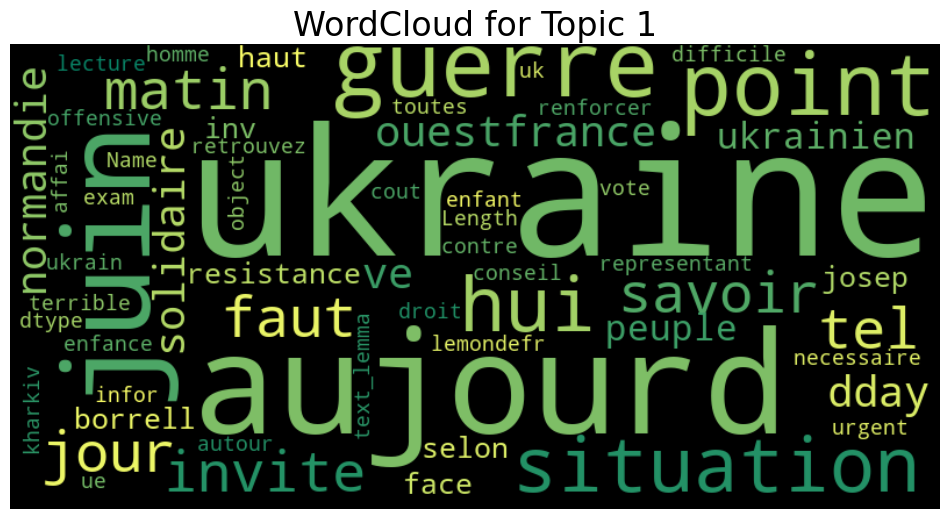

/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/mamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

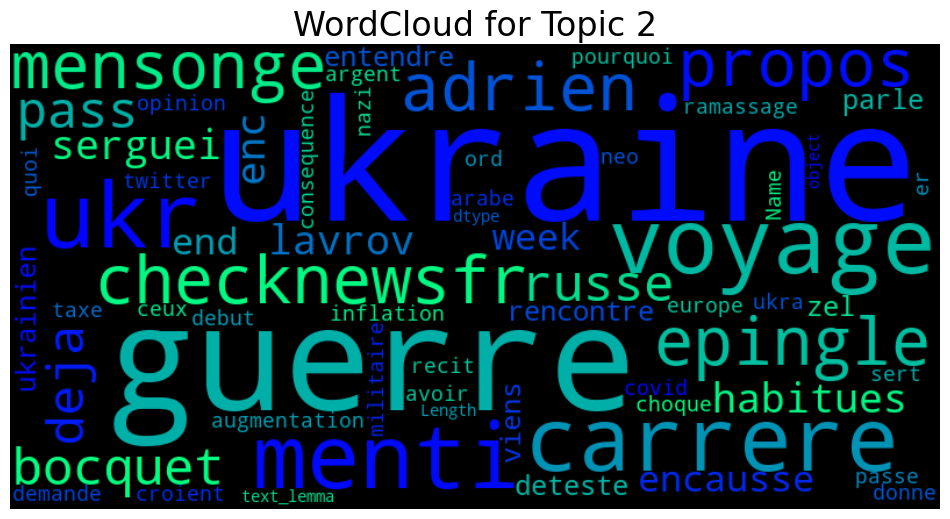

In [51]:

make_cloud(data, df_dominant_topics_lemma, "lemma")
make_cloud(data, df_dominant_topics_bigrame, "lemma_bigrame")
make_cloud(data, df_dominant_topics_stem, "stem")

In [52]:
### Word count and importance of key terms into the "optimal" topics

word  topic_id  importance  word_count
0     ete         0    0.024455        1220
1  depuis         0    0.020535        1030
2    kiev         0    0.019015        1197
3   cette         0    0.017311        1438
4   apres         0    0.016841         906

In [55]:
topics = lda_lemma.show_topics(formatted=False)
data_flat = [word for word_list in text_tokens_lemma for word in word_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [58]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from plotly.subplots import make_subplots

nb_topics = df["topic_id"].unique()
fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    fig.add_trace(go.Bar(x=df[df['topic_id']==i]["word"], y=df[df['topic_id']==i]['word_count']),
                        row=i+1, col=1)
    fig.update_layout(barmode='stack',
                      xaxis={'categoryorder': 'total descending'})
fig.show()


fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    sizeref = df[df['topic_id']==i]["importance"].max() / 100 ** 2

    fig.add_trace(go.Scatter(x=df[df['topic_id']==i]["importance"],
                             y=df[df['topic_id']==i]['word_count'],
                             text=df[df['topic_id']==i]["word"],
                             marker_size=df[df['topic_id']==i]["importance"]),
                        row=i+1, col=1)
    fig.update_traces(mode='markers', marker=dict(sizemode='area',
                                              line_width=2))
fig.show()

# fig = px.scatter(df[df['topic_id']==0], x="importance", y='word_count', color='word', size='importance' )
# fig.show()

0
1
2


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [33]:
df_dominant_topics.head()

Dominant_Topic  Perc_Contribution  \
0               4             0.4574   
1               1             0.2561   
2               4             0.3778   
3               4             0.3595   
4               4             0.3188   

                                      Topic_Keywords  \
0  guerre, france, plus, contre, europe, russie, ...   
1  poutine, macron, zelensky, otan, comme, presid...   
2  guerre, france, plus, contre, europe, russie, ...   
3  guerre, france, plus, contre, europe, russie, ...   
4  guerre, france, plus, contre, europe, russie, ...   

                                                   0  
0  [voila, info, malheureusement, tres, peu, repr...  
1           [ukraine, face, poutine, macron, hausse]  
2  [crise, ukraine, emmanuel, macron, vladimir, p...  
3  [russie, equivalent, pib, italie, attention, s...  
4  [crise, ukraine, voila, pourquoi, faut, sortir...

In [34]:
fig = px.bar(df_dominant_topics, x=' 	Dominant_Topic', y='pop')

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
19739        19739               4              0.3047   
19740        19740               0              0.2768   
19741        19741               3              0.2985   
19742        19742               1              0.3527   
19743        19743               1              0.2381   
19744        19744               4              0.3361   
19745        19745               1              0.3105   
19746        19746               4              0.2951   
19747        19747               4              0.3462   
19748        19748               1              0.3927   

                                                Keywords  \
19739  guerre, france, plus, contre, europe, russie, ...   
19740  ete, depuis, kiev, cette, apres, jour, francai...   
19741  ukrainien, russie, ue, pays, arme, monde, forc...   
19742  poutine, macron, zelensky, otan, comme, presid...   
19743  poutine, macron, zelensky, otan, comme, presid...   
19744  guerre, france, plus, contre, europe, russie, ...   
19745  poutine, macron, zelensky, otan, comme, presid...   
19746  guerre, france, plus, contre, europe, russie, ...   
19747  guerre, france, plus, contre, europe, russie, ...   
19748  poutine, macron, zelensky, otan, comme, presid...   

                                                    Text  
19739  [image, pleine, preparation, guerre, incroyabl...  
19740  [politique, commerciale, mobilisee, soutenir, ...  
19741  [pilonnees, depuis, cote, troupe, kremlin, qui...  
19742  [ukraine, serguei, jirnov, amp, valerie, pecre...  
19743  [ukraine, vpecresse, kiev, urgence, hiver, arr...  
19744  [magnifique, tellement, emouvant, ukraine, eur...  
19745  [guerre, ukraine, faire, aider, population, vp...  
19746  [guerre, ukraine, soft, power, reseaux, sociau...  
19747  [implacable, gauche, peuple, ukraine, compris,...  
19748  [urgence, hopital, ferment, faute, soignant, a...

### La sentence la plus représentative de chaque topic

In [41]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative_Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.4672   
1          1              0.5489   
2          2              0.4381   
3          3              0.5398   
4          4              0.5431   

                                            Keywords  \
0  ete, depuis, kiev, cette, apres, jour, francai...   
1  poutine, macron, zelensky, otan, comme, presid...   
2  russe, armee, direct, mort, personne, annonce,...   
3  ukrainien, russie, ue, pays, arme, monde, forc...   
4  guerre, france, plus, contre, europe, russie, ...   

                                 Representative_Text  
0  [guerre, ukraine, corps, retrouves, main, liee...  
1  [jamais, si, bien, servi, soi, meme, france, m...  
2  [flash, ukraine, troupe, russe, approche, kher...  
3  [pologne, slovaquie, roumanie, hongrie, pays, ...  
4  [air, presidentielle, soir, france, tv, caroli...

In [40]:
sent_topics_sorteddf_mallet.shape

(5, 4)